In [2]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse, schedule

from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional, Union

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_14461/2268176252.py:19: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [4]:
DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

## Acquisition Scan Experiment
Play a Constant Amplitude Measurement Pulse (Gaussian Square for more realistic effects)\
Vary a fixed duration short Acquisition Window across the Measurement Pulse (while accounting for system latency)\
Measure Fidelity and Blobs of each window, and hence get fidelity dynamics + IQ Blobs

In [5]:
# Acquisition Linspace Details

from helper_funcs.utils import *

acq_duration = 48

acq_latency_dt = get_closest_multiple_of_16(get_dt_from(320 * ns))
acq_latency_sec = acq_latency_dt * dt

init_time_sec = 150.0 * ns
total_duration_sec = get_closest_multiple_of_16(get_dt_from(425 * ns)) * dt

fine_kappas_linspace = np.linspace(init_time_sec, total_duration_sec, int(get_dt_from(total_duration_sec - init_time_sec) / acq_duration))
print(len(fine_kappas_linspace))

26


In [6]:
def ss_acq_scan_exp(amp, fine_linspace):
    exp_g = []
    exp_e = []

    m_pulse = pulse.GaussianSquare(
        duration=measure_pulse.duration,
        amp=amp,
        sigma=measure_pulse.sigma,
        width=measure_pulse.width,
        angle=measure_pulse.angle,
        limit_amplitude=True
    )

    for kappa_delay_sec in fine_linspace:
        kappa_delay_dt = get_closest_multiple_of_16(get_dt_from(kappa_delay_sec))

        with pulse.build(backend=backend, default_alignment='left', name=f'acq scan g delay: {int(1e3*kappa_delay_sec/ns)/1e3}') as acq_g_sched:
            meas_chan = pulse.measure_channel(qubit)
            acq_chan = pulse.acquire_channel(qubit)

            pulse.delay(acq_latency_dt, meas_chan)
            pulse.play(m_pulse, meas_chan)
            pulse.delay(kappa_delay_dt, acq_chan)
            pulse.acquire(
                duration=acq_duration,
                qubit_or_channel=acq_chan,
                register=pulse.MemorySlot(qubit)
            )
        exp_g.append(acq_g_sched)
        
        with pulse.build(backend=backend, default_alignment='left', name=f'acq scan e delay: {int(1e3*kappa_delay_sec/ns)/1e3}') as acq_e_sched:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)
            acq_chan = pulse.acquire_channel(qubit)

            with pulse.align_right():
                pulse.delay(acq_latency_dt, meas_chan)
                pulse.play(x_pulse, qubit_chan)
            pulse.play(m_pulse, meas_chan)
            pulse.delay(kappa_delay_dt, acq_chan)
            pulse.acquire(
                duration=acq_duration,
                qubit_or_channel=acq_chan,
                register=pulse.MemorySlot(qubit)
            )
        exp_e.append(acq_e_sched)
    return exp_g, exp_e

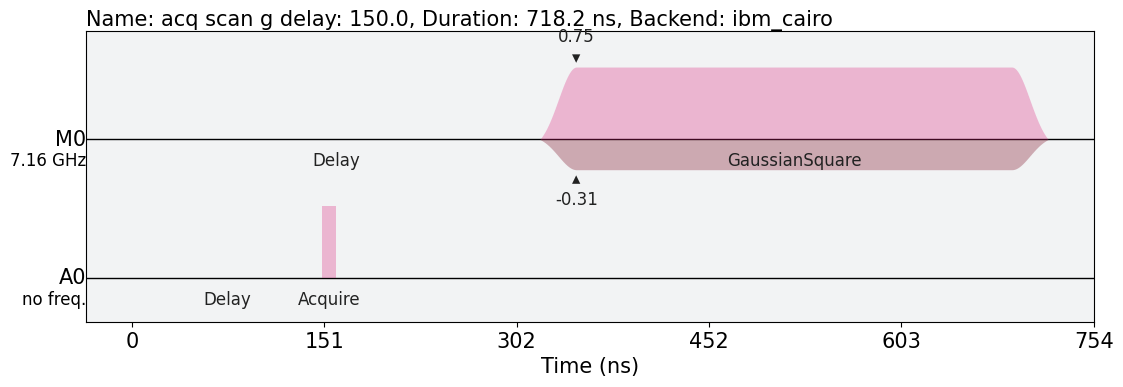

In [7]:
def flatten(inp_list):
    arr = np.array(inp_list).reshape(-1)
    return arr.tolist()

amps_linspace = np.linspace(0.38, 0.99, 15)

all_exp_g = []
all_exp_e = []

for amp in amps_linspace:
    temp_g, temp_e = ss_acq_scan_exp(amp, fine_linspace=fine_kappas_linspace)
    all_exp_g.append(temp_g)
    all_exp_e.append(temp_e)

batch_1_g = flatten(all_exp_g[:5])
batch_2_g = flatten(all_exp_g[5:10])
batch_3_g = flatten(all_exp_g[10:15])

batch_1_e = flatten(all_exp_e[:5])
batch_2_e = flatten(all_exp_e[5:10])
batch_3_e = flatten(all_exp_e[10:15])

batch_3_g[0].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

In [8]:
num_shots = 4096
rep_delay = 499.0 * 1e-6

exp_1 = batch_1_g + batch_1_e
exp_2 = batch_2_g + batch_2_e
exp_3 = batch_3_g + batch_3_e

acquisition_checker(exp_1)
acquisition_checker(exp_2)
acquisition_checker(exp_3)
print(len(exp_1))
print(len(exp_2))
print(len(exp_3))

260
260
260


In [43]:
# Running exp_1, exp_2, and exp_3

job_experiment = backend.run(exp_3, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is queued (None)

KeyboardInterrupt: 

In [9]:
job_1 = provider.backend.retrieve_job('cp6y4bhprheg008rak2g')
job_2 = provider.backend.retrieve_job('cp6y4gjmbjng0085dr90')
job_3 = provider.backend.retrieve_job('cp6y4ptmbjng0085drag')

In [10]:
result_1 = get_results_arr(job_1.result(timeout=120), qubit=qubit)
result_2 = get_results_arr(job_2.result(timeout=120), qubit=qubit)
result_3 = get_results_arr(job_3.result(timeout=120), qubit=qubit)

In [11]:
print(result_1.shape)
print(result_2.shape)
print(result_3.shape)

(260, 4096)
(260, 4096)
(260, 4096)


In [14]:
result_1 = result_1.reshape(10, -1, num_shots)
result_2 = result_2.reshape(10, -1, num_shots)
result_3 = result_3.reshape(10, -1, num_shots)

result_1_g = result_1[:5]
result_1_e = result_1[5:]

result_2_g = result_2[:5]
result_2_e = result_2[5:]

result_3_g = result_3[:5]
result_3_e = result_3[5:]

big_results_g = np.concatenate((result_1_g, result_2_g, result_3_g), axis=0)
big_results_e = np.concatenate((result_1_e, result_2_e, result_3_e), axis=0)

In [26]:
import math

def classify(point: complex, mean_a, mean_b):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_b) < distance(point, mean_a))

def get_fidelity(array_g, array_e):
    '''
    Array inputs need to be of shape (num_exp, num_shots)
    '''
    means_g = np.mean(array_g, axis=-1)
    means_e = np.mean(array_e, axis=-1)

    fidelity_arr = np.zeros(len(means_g))

    for ind, (g_mean, e_mean) in enumerate(zip(means_g, means_e)):
        g_gnd = 0
        g_exc = 0

        e_gnd = 0
        e_exc = 0

        for result in array_g[ind]:
            res = classify(result, g_mean, e_mean)
            if res == 0:
                g_gnd += 1
            if res == 1:
                g_exc += 1
            
        for result in array_e[ind]:
            res = classify(result, g_mean, e_mean)
            if res == 0:
                e_gnd += 1
            if res == 1:
                e_exc += 1
        
        fidelity = 1.0 - 0.5 * (g_exc + e_gnd) / num_shots
        fidelity_arr[ind] = fidelity
    return fidelity_arr

In [27]:
big_fidelity = np.zeros((15, len(fine_kappas_linspace)))
for ind, (res_g, res_e) in enumerate(zip(big_results_g, big_results_e)):
    print(res_g.shape)
    fidelity = get_fidelity(res_g, res_e)
    big_fidelity[ind] = fidelity

(26, 4096)
(26, 4096)
(26, 4096)
(26, 4096)
(26, 4096)
(26, 4096)
(26, 4096)
(26, 4096)
(26, 4096)
(26, 4096)
(26, 4096)
(26, 4096)
(26, 4096)
(26, 4096)
(26, 4096)


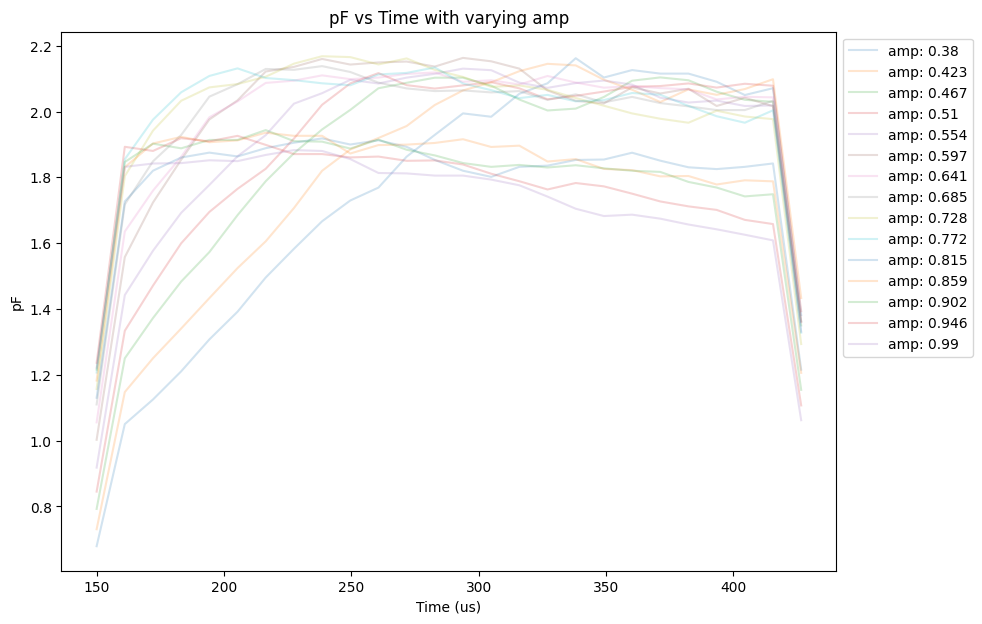

In [49]:
big_pF = -np.log10(1. - big_fidelity)
for i in range(len(big_pF)):
    big_pF[i] = np.convolve(big_pF[i], np.ones(3)/3, mode='same')
max_pFs = np.max(big_pF, axis=-1)
ind_pFs = np.argmax(big_pF, axis=-1)
plt.figure(figsize=(10.,7.))
for ind, pF_res in enumerate(big_pF):
    plt.plot(fine_kappas_linspace/ns, pF_res, label=f'amp: {int(1e3*amps_linspace[ind])/1e3}', alpha=0.2)
plt.legend(bbox_to_anchor=(1,1,))
plt.xlabel('Time (us)')
plt.ylabel('pF')
plt.title('pF vs Time with varying amp')
plt.show()

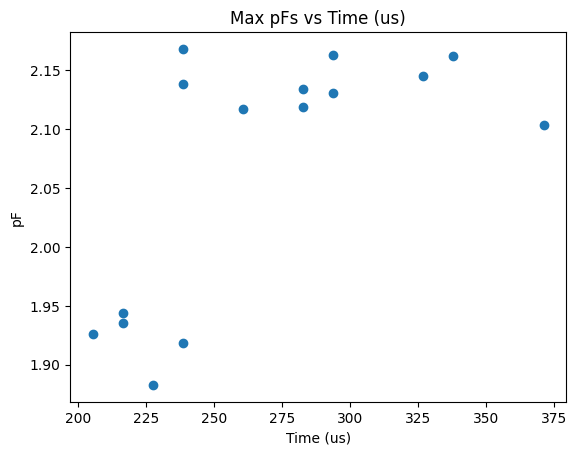

In [50]:
plt.scatter(fine_kappas_linspace[ind_pFs]/ns, max_pFs)
plt.xlabel('Time (us)')
plt.ylabel('pF')
plt.title('Max pFs vs Time (us)')
plt.show()

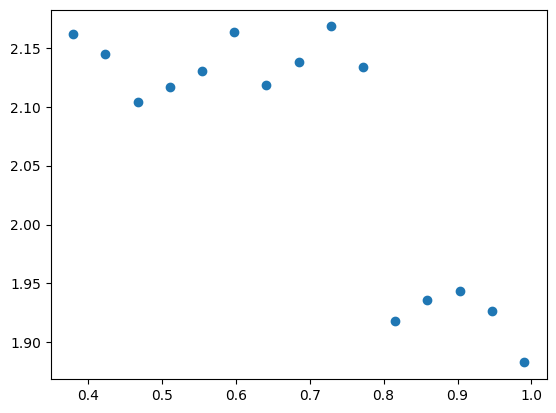

In [51]:
plt.scatter(amps_linspace, max_pFs)
plt.show()

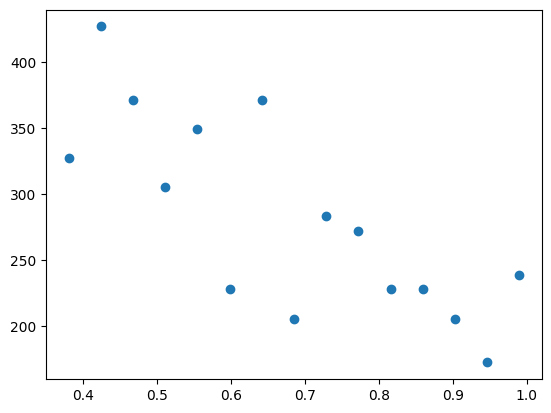

In [47]:
plt.scatter(amps_linspace, fine_kappas_linspace[ind_pFs]/ns)
plt.show()